<a href="https://colab.research.google.com/github/bernaldiaz/curso-numerico-3/blob/main/T10EDOs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tema 10 - EDOs

## Librerías y Funciones Necesarias

In [ ]:
import math
import numpy as np
import pandas as pd
import sympy as sp
from sympy.solvers import solve
from plotnine import *
import functools

In [ ]:
def NewtonRaphson(x0, f, symbol, TOL = 1e-10, nMax = 100, verbose = False):
    """
    Dada una función f definida en los números reales dónde f'(x0) és distinto de 0, 
    devuelve un cero de la función usando el método de Newton-Raphson.
    
    Args:
        x0: (float) Valor inicial
        TOL: (float) Tolerancia
        nMax: (int) Número máximo de iteraciones
        f: (fun) Función definida en los números reales
        symbol: (Symbol) Variable independiente de la función f
        verbose: (bool) Para mostrar o no los resultados relevantes
    
    Returns: 
        cero: (float) Valor que se aproxima a un cero de f
    """ 

    cero = x0
    aux = x0 + 1
    fd = sp.diff(f, symbol)
    for _ in range(nMax):
        if abs(cero - aux) < TOL:
            if verbose:
                print("cero =", cero)
            return cero
        aux = cero
        cero -= f.evalf(subs = {symbol: cero}) / fd.evalf(subs = {symbol: cero})

    print("Se ha superado el número máximo de iteraciones.")   
    return 

In [ ]:
def HelperPlot(df):
    """
    Dado un dataframe df que contiene las columnas t, yHat e y, muestra un 
    gráfico donde se muestran yHat e y en función de t
    
    Args:
        df: (Dataframe) Solución de los métodos del tema 10 del curso
    """ 
    
    h = df["t"][1] - df["t"][0]
    dmod = pd.melt(df, id_vars=["t"], value_vars = ["y", "yHat"]) 
    p = ggplot(dmod, aes(x = "t", y = "value", color = "variable", 
                        linetype = "variable", size = "variable"))
    (p + geom_line()
    + geom_point()
    + ylab("")
    + xlim(df["t"].iloc[0] - h, df["t"].iloc[-1] + h)
    + scale_color_manual(["blue", "red"], name = "Funciones")
    + scale_linetype_manual(["solid", ""], name = "Funciones")
    + scale_shape_manual([20, 19], name = "Funciones")
    + scale_size_manual([0.5, 2], name = "Funciones")    
    ).draw();


In [ ]:
def HelperPlotSistema(df):
    """
    Dado un dataframe df que contiene las columnas t, yHat1, ..., yHatm, e y1, ..., ym, 
    muestra un gráfico donde se muestran yHat_i e y_i en función de t
    
    Args:
        df: (Dataframe) Solución de los métodos del tema 10 del curso
    """ 
    
    h = df["t"][1] - df["t"][0]
    m = int(len(df.columns) / 2 - 1)

    yVars = ["y" + str(i) for i in range(1, m + 1)]
    yHatVars = ["yHat" + str(i) for i in range(1, m + 1)]

    ydf = pd.melt(df, id_vars = ["t"], value_vars = yVars,
                   var_name = "yVar", value_name = "yVal")
    
    yHatdf = pd.melt(df, id_vars = ["t"], value_vars = yHatVars,
                   var_name = "yHatVar", value_name = "yHatVal")
    yHatdf.drop("t", inplace = True, axis = 1)

    dmod = pd.concat([ydf, yHatdf], axis = 1)

    colorsBright = ["#FF0000", "#FFA500", "#FFFF00", "#008000", "#0000FF", "#4B0082", "#EE82EE"]
    colorsDark = ["#CC0000", "#CC8500", "#CCCC00", "#004D00", "#0000CC", "#2E004F", "#BA66BA"]

    p = ggplot(dmod, aes(x = "t"))
    (p 
     + geom_line(aes(y = "yVal", color = "yVar"), size = 0.5)
     + scale_color_manual(colorsDark[:m], name = "Funciones y_i")
     + geom_point(aes(y = "yHatVal", fill = "yHatVar"), size = 2)
     + scale_fill_manual(colorsDark[:m], name = "Funciones yHat_i")
     + ylab("")
     + xlim(df["t"].iloc[0] - h, df["t"].iloc[-1] + h)
     ).draw();


In [ ]:
def DerivadaFOrdenN(f, n, tSymbol, ySymbol):
  f_original = f
  for _ in range(n):
    f = sp.simplify(sp.diff(f, tSymbol) + sp.diff(f, ySymbol) * f_original)

  return f

## Método de Euler

El **Método de Euler** ofrece la solución aproximada en el punto del mallado $t_{i + 1} = t_i + h$, $\hat{y}_{i + 1} = \hat{y}(t_i + h)$, usando la siguiente expresión del desarrollo de Taylor de la función $\hat{y}(t)$:

$$\hat{y}_{i + 1} = \hat{y}_i + h\cdot f(t_i, \hat{y}_i),\qquad i = 0,\dots, n - 1,\quad \hat{y}_0 = y_0$$

In [ ]:
def MetodoEuler(a, b, n, y0, f, y = None, verbose = False, complete = False):
    """
    Ofrece una solución aproximada en el punto del mallado 
    t_{i + 1} = t_i + h, y^{hat}_{i + 1} = y^{hat}(t_i + h)  

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        n: (int) Número de aproximaciones
        y0: (float) Condición inicial
        f: (fun) Función f(t, y)
        y: (fun) Función y(t) original. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces y debe ser distinto de None

    Returns:
        yHat: (ndarray) Vector de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and y == None:
        print("Si complete = True, entonces debes indicar una función para el parámetro y")
        return

    h = (b - a) / n
    if (verbose):
        print("h =", h, end = "\n\n")

    t = np.zeros(n + 1) # Ponemos n + 1 porque también incluimos el índice 0
    t[0] = a

    yHat = np.zeros(n + 1)
    yHat[0] = y0 # La primera componente del vector de aproximaciones vale la condición inicial

    if (y != None):
        yOriginal = np.zeros(n + 1)
        yOriginal[0] = y(t[0])

    for i in range(1, n + 1):
        t[i] = a + i * h 
        yHat[i] = yHat[i - 1] + h * f(t[i - 1], yHat[i - 1]) # Calculamos yHat(t + i * h)
        if (y != None):
            yOriginal[i] = y(t[i])

        
    
    data = pd.DataFrame({"t": t, "yHat": yHat})
    if (y != None):
        data["y"] = yOriginal
        data["|y - yHat|"] = abs(yOriginal - yHat)
    if verbose:
        print(data)
    
    if complete:
        return data
    return yHat

In [ ]:
a = 1
b = 3
n = 20 # De este modo conseguimos h = 0.1
y0 = 2

def f(t, y):
    return (1 + t) / (1 + y)

def y(t):
    return math.sqrt(math.pow(t, 2) + 2 * t + 6) - 1

In [ ]:
yHat = MetodoEuler(a, b, n, y0, f, y = y, verbose = True)

h = 0.1

      t      yHat         y  |y - yHat|
0   1.0  2.000000  2.000000    0.000000
1   1.1  2.066667  2.067572    0.000906
2   1.2  2.135145  2.136877    0.001733
3   1.3  2.205317  2.207803    0.002486
4   1.4  2.277073  2.280244    0.003171
5   1.5  2.350309  2.354102    0.003793
6   1.6  2.424929  2.429286    0.004357
7   1.7  2.500843  2.505710    0.004867
8   1.8  2.577967  2.583295    0.005327
9   1.9  2.656224  2.661967    0.005743
10  2.0  2.735541  2.741657    0.006117
11  2.1  2.815850  2.822303    0.006453
12  2.2  2.897090  2.903844    0.006754
13  2.3  2.979203  2.986226    0.007023
14  2.4  3.062134  3.069398    0.007264
15  2.5  3.145834  3.153312    0.007478
16  2.6  3.230256  3.237924    0.007668
17  2.7  3.315357  3.323193    0.007836
18  2.8  3.401098  3.409082    0.007984
19  2.9  3.487440  3.495553    0.008114
20  3.0  3.574349  3.582576    0.008227


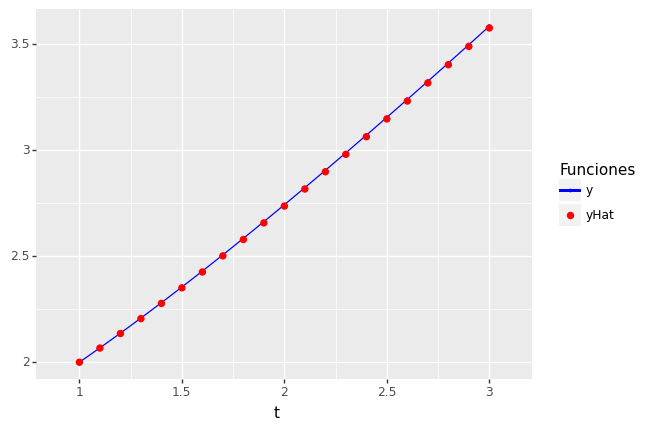

In [ ]:
df = MetodoEuler(a, b, n, y0, f, y = y, verbose = False, complete = True)
HelperPlot(df)

## Método de Taylor de orden 2

El **Método de Taylor de orden 2** resuelve la ecuación en diferencias siguiente

$$\hat{y}_{i + 1} = \hat{y}_i + h\left(f_i + \frac{h}{2}\left(f_{t,i}^{(1)} + f_{y, i}^{(1)}\cdot f_i\right)\right),\quad \hat{y}_0 = y_0$$

siendo,

$$f_i = f\left(f_i, \hat{y}_i\right),\quad f_{t, i}^{(1)} = \frac{\partial f}{\partial t}\left(t_i, \hat{y}_i\right),\quad f_{y, i}^{(1)} = \frac{\partial f}{\partial y}\left(t_i, \hat{y}_i\right)$$

In [ ]:
def MetodoTaylor2(a, b, n, y0, f, ft, fy, y = None, verbose = False, complete = False):
    """
    Ofrece una solución a la ecuación en diferencias mostrada
    anteriormente

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        n: (int) Número de aproximaciones
        y0: (float) Condición inicial
        f: (fun) Función f(t, y)
        ft: (fun) Función f_{t}(t, y)
        fy: (fun) Función f_{y}(t, y)
        y: (fun) Función y(t) original. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces y debe ser distinto de None

    Returns:
        yHat: (ndarray) Vector de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and y == None:
        print("Si complete = True, entonces debes indicar una función para el parámetro y")
        return

    h = (b - a) / n
    if (verbose):
        print("h =", h, end = "\n\n")

    t = np.zeros(n + 1) # Ponemos n + 1 porque también incluimos el índice 0
    t[0] = a

    yHat = np.zeros(n + 1)
    yHat[0] = y0 # La primera componente del vector de aproximaciones vale la condición inicial
    if (y != None):
        yOriginal = np.zeros(n + 1)
        yOriginal[0] = y(t[0])

    for i in range(1, n + 1):
        t[i] = a + i * h 
        yHat[i] = yHat[i - 1] + h * (f(t[i - 1], yHat[i - 1]) + h / 2 * (ft(t[i - 1], yHat[i - 1]) + fy(t[i - 1], yHat[i - 1]) * f(t[i - 1], yHat[i - 1])))
        if (y != None):
            yOriginal[i] = y(t[i])

    data = pd.DataFrame({"t": t, "yHat": yHat})
    if (y != None):
        data["y"] = yOriginal
        data["|y - yHat|"] = abs(yOriginal - yHat)
    if verbose:
        print(data)
    
    if complete:
        return data
    return yHat

In [ ]:
a = 1
b = 3
n = 20 # De este modo conseguimos h = 0.1
y0 = 2

def f(t, y):
    return (1 + t) / (1 + y)

def ft(t, y):
    return 1 / (1 + y)

def fy(t, y):
    return -(1 + t) / math.pow(1 + y, 2)

def y(t):
    return math.sqrt(math.pow(t, 2) + 2 * t + 6) - 1

In [ ]:
yHat = MetodoTaylor2(a, b, n, y0, f, ft, fy, y = y, verbose = True)

h = 0.1

      t      yHat         y  |y - yHat|
0   1.0  2.000000  2.000000    0.000000
1   1.1  2.067593  2.067572    0.000020
2   1.2  2.136916  2.136877    0.000039
3   1.3  2.207859  2.207803    0.000056
4   1.4  2.280315  2.280244    0.000071
5   1.5  2.354187  2.354102    0.000085
6   1.6  2.429383  2.429286    0.000098
7   1.7  2.505819  2.505710    0.000109
8   1.8  2.583414  2.583295    0.000119
9   1.9  2.662095  2.661967    0.000128
10  2.0  2.741794  2.741657    0.000136
11  2.1  2.822447  2.822303    0.000144
12  2.2  2.903994  2.903844    0.000150
13  2.3  2.986382  2.986226    0.000155
14  2.4  3.069558  3.069398    0.000160
15  2.5  3.153476  3.153312    0.000165
16  2.6  3.238092  3.237924    0.000168
17  2.7  3.323365  3.323193    0.000171
18  2.8  3.409256  3.409082    0.000174
19  2.9  3.495730  3.495553    0.000176
20  3.0  3.582754  3.582576    0.000178


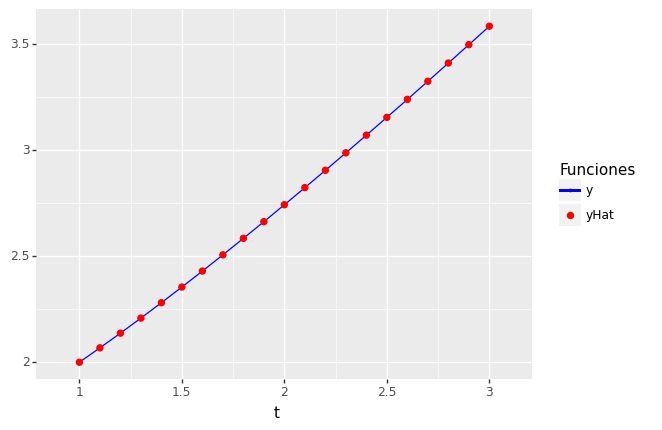

In [ ]:
df = MetodoTaylor2(a, b, n, y0, f, ft, fy, y = y, verbose = False, complete = True)
HelperPlot(df)

### Método de Taylor de orden 2 con `sympy`


In [ ]:
def MetodoTaylor2Sympy(a, b, n, y0, f, tSymbol, ySymbol, y = None, verbose = False, complete = False):
    """
    Ofrece una solución a la ecuación en diferencias mostrada
    anteriormente

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        n: (int) Número de aproximaciones
        y0: (float) Condición inicial
        f: (sympy expr) Función f(t, y)
        tSymbol: (Symbol) Símbolo de sympy que representa a la variable t de la función f
        ySymbol: (Symbol) Símbolo de sympy que representa a la variable y de la función f
        y: (fun) Función y(t) original. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces y debe ser distinto de None

    Returns:
        yHat: (ndarray) Vector de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and y == None:
        print("Si complete = True, entonces debes indicar una función para el parámetro y")
        return

    ft = sp.diff(f, tSymbol)
    fy = sp.diff(f, ySymbol)

    h = (b - a) / n
    if (verbose):
        print("h =", h, end = "\n\n")

    t = np.zeros(n + 1) # Ponemos n + 1 porque también incluimos el índice 0
    t[0] = a

    yHat = np.zeros(n + 1)
    yHat[0] = y0 # La primera componente del vector de aproximaciones vale la condición inicial
    if (y != None):
        yOriginal = np.zeros(n + 1)
        yOriginal[0] = y(t[0])

    for i in range(1, n + 1):
        t[i] = a + i * h 
        yHat[i] = yHat[i - 1] + h * (f.evalf(subs = {tSymbol: t[i - 1], ySymbol: yHat[i - 1]}) + 
                                     h / 2 * (ft.evalf(subs = {tSymbol: t[i - 1], ySymbol: yHat[i - 1]}) + 
                                              fy.evalf(subs = {tSymbol: t[i - 1], ySymbol: yHat[i - 1]}) * 
                                              f.evalf(subs = {tSymbol: t[i - 1], ySymbol: yHat[i - 1]})))
        if (y != None):
            yOriginal[i] = y(t[i])

    data = pd.DataFrame({"t": t, "yHat": yHat})
    if (y != None):
            data["y"] = yOriginal
            data["|y - yHat|"] = abs(yOriginal - yHat)
    if verbose:
        print(data)
    
    if complete:
        return data
    return yHat

In [ ]:
a = 1
b = 3
n = 20 # De este modo conseguimos h = 0.1
y0 = 2

tSymb = sp.Symbol('tSymb')
ySymb = sp.Symbol('ySymb')

f = (1 + tSymb) / (1 + ySymb)

def y(t):
    return math.sqrt(math.pow(t, 2) + 2 * t + 6) - 1

In [ ]:
yHat = MetodoTaylor2Sympy(a, b, n, y0, f, tSymb, ySymb, y = y, verbose = True)

h = 0.1

      t      yHat         y  |y - yHat|
0   1.0  2.000000  2.000000    0.000000
1   1.1  2.067593  2.067572    0.000020
2   1.2  2.136916  2.136877    0.000039
3   1.3  2.207859  2.207803    0.000056
4   1.4  2.280315  2.280244    0.000071
5   1.5  2.354187  2.354102    0.000085
6   1.6  2.429383  2.429286    0.000098
7   1.7  2.505819  2.505710    0.000109
8   1.8  2.583414  2.583295    0.000119
9   1.9  2.662095  2.661967    0.000128
10  2.0  2.741794  2.741657    0.000136
11  2.1  2.822447  2.822303    0.000144
12  2.2  2.903994  2.903844    0.000150
13  2.3  2.986382  2.986226    0.000155
14  2.4  3.069558  3.069398    0.000160
15  2.5  3.153476  3.153312    0.000165
16  2.6  3.238092  3.237924    0.000168
17  2.7  3.323365  3.323193    0.000171
18  2.8  3.409256  3.409082    0.000174
19  2.9  3.495730  3.495553    0.000176
20  3.0  3.582754  3.582576    0.000178


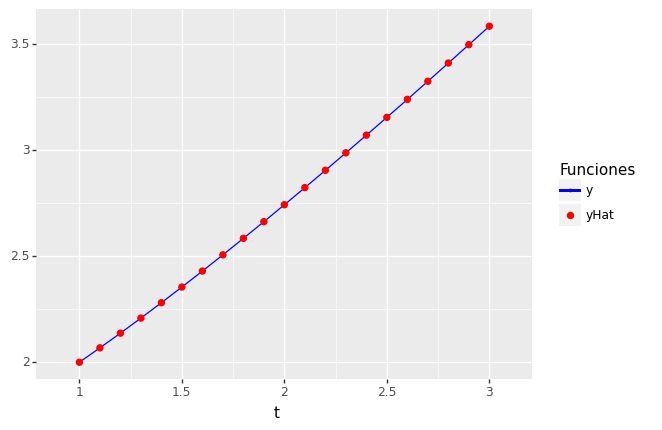

In [ ]:
df = MetodoTaylor2Sympy(a, b, n, y0, f, tSymb, ySymb, y = y, verbose = False, complete = True)
HelperPlot(df)

### Método de Taylor de orden $k$ con `sympy`

In [ ]:
def MetodoTaylorKSympy(a, b, n, y0, k, f, tSymbol, ySymbol, y = None, verbose = False, complete = False):
    """
    Ofrece una solución a la ecuación en diferencias mostrada
    anteriormente

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        n: (int) Número de aproximaciones
        y0: (float) Condición inicial
        k: (int) Orden del Método de Taylor
        f: (sympy expr) Función f(t, y)
        tSymbol: (Symbol) Símbolo de sympy que representa a la variable t de la función f
        ySymbol: (Symbol) Símbolo de sympy que representa a la variable y de la función f
        y: (fun) Función y(t) original. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces y debe ser distinto de None

    Returns:
        yHat: (ndarray) Vector de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and y == None:
        print("Si complete = True, entonces debes indicar una función para el parámetro y")
        return

    h = (b - a) / n
    if (verbose):
        print("h =", h, end = "\n\n")

    t = np.zeros(n + 1) # Ponemos n + 1 porque también incluimos el índice 0
    t[0] = a

    yHat = np.zeros(n + 1)
    yHat[0] = y0 # La primera componente del vector de aproximaciones vale la condición inicial
    if (y != None):
        yOriginal = np.zeros(n + 1)
        yOriginal[0] = y(t[0])

    for i in range(1, n + 1):
        t[i] = a + i * h 
        aux = yHat[i - 1] + h * f.evalf(subs = {tSymbol: t[i - 1], ySymbol: yHat[i - 1]})
        for j in range(1, k):
            aux += (math.pow(h, j + 1) / math.factorial(j + 1) * 
                    DerivadaFOrdenN(f, j, tSymbol, ySymbol).evalf(subs = {tSymbol: t[i - 1], ySymbol: yHat[i - 1]}))

        yHat[i] = aux
        if (y != None):
            yOriginal[i] = y(t[i])

    data = pd.DataFrame({"t": t, "yHat": yHat})
    if (y != None):
            data["y"] = yOriginal
            data["|y - yHat|"] = abs(yOriginal - yHat)
    if verbose:
        print(data)
    
    if complete:
        return data
    return yHat

In [ ]:
a = 1
b = 3
n = 20 # De este modo conseguimos h = 0.1
y0 = 2
k = 4

tSymb = sp.Symbol('tSymb')
ySymb = sp.Symbol('ySymb')

f = (1 + tSymb) / (1 + ySymb)

def y(t):
    return math.sqrt(math.pow(t, 2) + 2 * t + 6) - 1

In [ ]:
yHat = MetodoTaylorKSympy(a, b, n, y0, k, f, tSymb, ySymb, y = y, verbose = True)

h = 0.1

      t      yHat         y    |y - yHat|
0   1.0  2.000000  2.000000  0.000000e+00
1   1.1  2.067572  2.067572  7.828791e-10
2   1.2  2.136877  2.136877  2.317365e-09
3   1.3  2.207803  2.207803  4.384810e-09
4   1.4  2.280244  2.280244  6.804707e-09
5   1.5  2.354102  2.354102  9.431442e-09
6   1.6  2.429286  2.429286  1.215023e-08
7   1.7  2.505710  2.505710  1.487279e-08
8   1.8  2.583295  2.583295  1.753312e-08
9   1.9  2.661967  2.661967  2.008353e-08
10  2.0  2.741657  2.741657  2.249116e-08
11  2.1  2.822303  2.822303  2.473490e-08
12  2.2  2.903844  2.903844  2.680282e-08
13  2.3  2.986226  2.986226  2.868998e-08
14  2.4  3.069398  3.069398  3.039670e-08
15  2.5  3.153312  3.153312  3.192712e-08
16  2.6  3.237924  3.237924  3.328806e-08
17  2.7  3.323193  3.323193  3.448817e-08
18  2.8  3.409082  3.409082  3.553718e-08
19  2.9  3.495553  3.495553  3.644545e-08
20  3.0  3.582576  3.582576  3.722352e-08


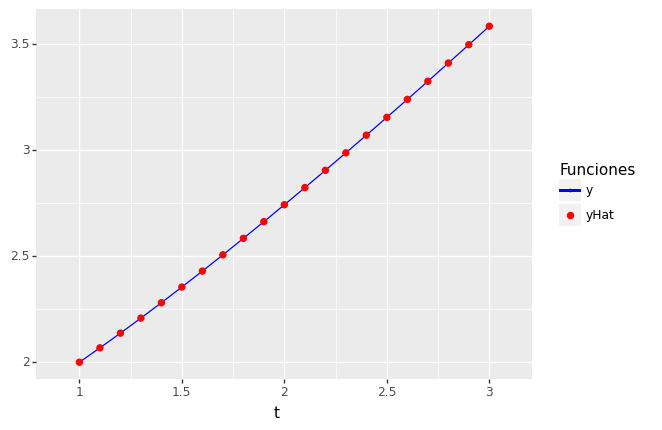

In [ ]:
df = MetodoTaylorKSympy(a, b, n, y0, k, f, tSymb, ySymb, y = y, verbose = False, complete = True)
HelperPlot(df)

## Método del Trapecio

El **Método del Trapecio** es un **método implícito** consistente con orden de convergencia 2.

$$\hat{y}_{i + 1} = \hat{y}_i + \frac{h}{2}\left(f\left(t_i, \hat{y}_i\right) + f\left(t_{i + 1}, \hat{y}_{i + 1}\right) \right)$$

In [ ]:
def MetodoTrapecio(a, b, n, y0, f, y = None, verbose = False, complete = False):
    """
    Calcula una solución a la ecuación en diferencias mostrada
    anteriormente

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        n: (int) Número de aproximaciones
        y0: (float) Condición inicial
        f: (fun) Función f(t, y)
        y: (fun) Función y(t) original. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces y debe ser distinto de None

    Returns:
        yHat: (ndarray) Vector de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and y == None:
        print("Si complete = True, entonces debes indicar una función para el parámetro y")
        return

    h = (b - a) / n
    if (verbose):
        print("h =", h, end = "\n\n")

    t = np.zeros(n + 1) # Ponemos n + 1 porque también incluimos el índice 0
    t[0] = a

    yHat = np.zeros(n + 1)
    yHat[0] = y0 # La primera componente del vector de aproximaciones vale la condición inicial
    if (y != None):
        yOriginal = np.zeros(n + 1)
        yOriginal[0] = y(t[0])
 
    x = sp.Symbol('x')

    for i in range(1, n + 1):
        g = yHat[i - 1] + h / 2 * (f(t[i - 1], yHat[i - 1]) + f(t[i - 1] + h, x)) - x

        t[i] = a + i * h 

        yHat[i] = NewtonRaphson(t[i - 1], g, x)

        if (y != None):
            yOriginal[i] = y(t[i])

        
    data = pd.DataFrame({"t": t, "yHat": yHat})
    if (y != None):
        data["y"] = yOriginal
        data["|y - yHat|"] = abs(yOriginal - yHat)
    if verbose:
        print(data)
    
    if complete:
        return data
    return yHat

In [ ]:
a = 1
b = 3
n = 20 # De este modo conseguimos h = 0.1
y0 = 2

def f(t, y):
    return (1 + t) / (1 + y)

def y(t):
    return math.sqrt(math.pow(t, 2) + 2 * t + 6) - 1

In [ ]:
yHat = MetodoTrapecio(a, b, n, y0, f, y = y, verbose = True)

h = 0.1

      t      yHat         y  |y - yHat|
0   1.0  2.000000  2.000000    0.000000
1   1.1  2.067562  2.067572    0.000010
2   1.2  2.136859  2.136877    0.000019
3   1.3  2.207776  2.207803    0.000027
4   1.4  2.280209  2.280244    0.000035
5   1.5  2.354061  2.354102    0.000041
6   1.6  2.429238  2.429286    0.000048
7   1.7  2.505657  2.505710    0.000053
8   1.8  2.583237  2.583295    0.000058
9   1.9  2.661904  2.661967    0.000062
10  2.0  2.741591  2.741657    0.000066
11  2.1  2.822233  2.822303    0.000070
12  2.2  2.903771  2.903844    0.000073
13  2.3  2.986151  2.986226    0.000076
14  2.4  3.069320  3.069398    0.000078
15  2.5  3.153232  3.153312    0.000080
16  2.6  3.237842  3.237924    0.000082
17  2.7  3.323110  3.323193    0.000083
18  2.8  3.408997  3.409082    0.000085
19  2.9  3.495468  3.495553    0.000086
20  3.0  3.582489  3.582576    0.000087


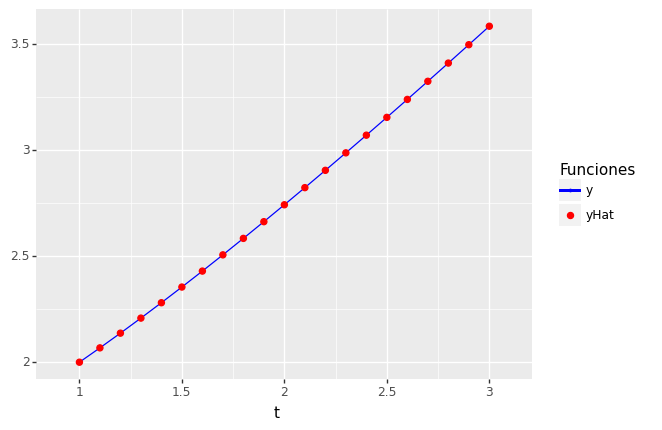

In [ ]:
df = MetodoTrapecio(a, b, n, y0, f, y = y, verbose = False, complete = True)
HelperPlot(df)

## Método de Euler Modificado

El **Método de Euler Modificado** es un ejemplo de **Método de Runge-Kutta** introductorio

$$\hat{y}_{i + 1} = \hat{y}_i + h\cdot f\left(t_i + \frac{h}{2}, \hat{y}_i + \frac{h}{2}\cdot f\left(t_i, \hat{y}_i\right)\right),\quad \hat{y}_0 = y_0$$

In [ ]:
def MetodoEulerModficado(a, b, n, y0, f, y = None, verbose = False, complete = False):
    """
    Calcula una solución a la ecuación en diferencias mostrada
    anteriormente

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        n: (int) Número de aproximaciones
        y0: (float) Condición inicial
        f: (fun) Función f(t, y)
        y: (fun) Función y(t) original. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces y debe ser distinto de None

    Returns:
        yHat: (ndarray) Vector de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and y == None:
        print("Si complete = True, entonces debes indicar una función para el parámetro y")
        return

    h = (b - a) / n
    if (verbose):
        print("h =", h, end = "\n\n")

    t = np.zeros(n + 1) # Ponemos n + 1 porque también incluimos el índice 0
    t[0] = a

    yHat = np.zeros(n + 1)
    yHat[0] = y0 # La primera componente del vector de aproximaciones vale la condición inicial
    if (y != None):
        yOriginal = np.zeros(n + 1)
        yOriginal[0] = y(t[0])

    for i in range(1, n + 1):
        t[i] = a + i * h 
        yHat[i] = yHat[i - 1] + h * f(t[i - 1] + h/2, yHat[i - 1] + h / 2 * f(t[i - 1], yHat[i - 1]))
        if (y != None):
            yOriginal[i] = y(t[i])

        
    data = pd.DataFrame({"t": t, "yHat": yHat})
    if (y != None):
        data["y"] = yOriginal
        data["|y - yHat|"] = abs(yOriginal - yHat)
    if verbose:
        print(data)
    
    if complete:
        return data
    return yHat

In [ ]:
a = 1
b = 3
n = 20 # De este modo conseguimos h = 0.1
y0 = 2

def f(t, y):
    return (1 + t) / (1 + y)

def y(t):
    return math.sqrt(math.pow(t, 2) + 2 * t + 6) - 1

In [ ]:
yHat = MetodoEulerModficado(a, b, n, y0, f, y = y, verbose = True)

h = 0.1

      t      yHat         y  |y - yHat|
0   1.0  2.000000  2.000000    0.000000
1   1.1  2.067582  2.067572    0.000010
2   1.2  2.136897  2.136877    0.000019
3   1.3  2.207831  2.207803    0.000028
4   1.4  2.280279  2.280244    0.000035
5   1.5  2.354144  2.354102    0.000042
6   1.6  2.429334  2.429286    0.000049
7   1.7  2.505764  2.505710    0.000054
8   1.8  2.583354  2.583295    0.000059
9   1.9  2.662030  2.661967    0.000064
10  2.0  2.741725  2.741657    0.000068
11  2.1  2.822374  2.822303    0.000071
12  2.2  2.903919  2.903844    0.000074
13  2.3  2.986304  2.986226    0.000077
14  2.4  3.069478  3.069398    0.000080
15  2.5  3.153394  3.153312    0.000082
16  2.6  3.238008  3.237924    0.000084
17  2.7  3.323278  3.323193    0.000085
18  2.8  3.409168  3.409082    0.000086
19  2.9  3.495641  3.495553    0.000088
20  3.0  3.582664  3.582576    0.000088


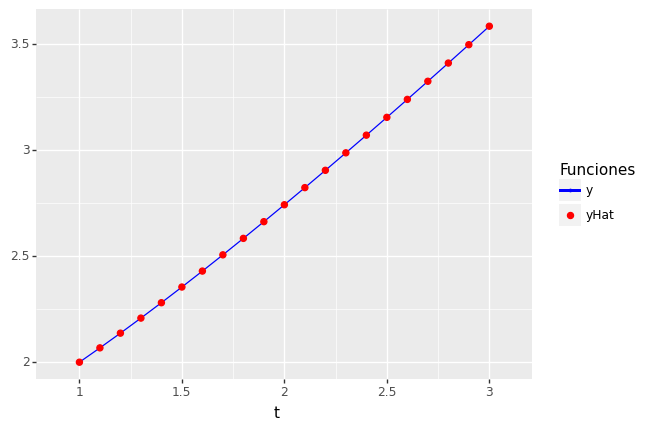

In [ ]:
df = MetodoEulerModficado(a, b, n, y0, f, y = y, verbose = False, complete = True)
HelperPlot(df)

## Método Runge-Kutta 4

Su expresión es:

$$\hat{y}_{i + 1} = \hat{y}_i + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4), \quad \hat{y}_0 = y_0$$
$$\begin{array}{rcl}
k_1 &=& f\left(t_i, \hat{y}_i\right)\\
k_2 &=& f\left(t_i + \frac{h}{2}, \hat{y}_i + \frac{hk_1}{2}\right)\\
k_3 &=& f\left(t_i + \frac{h}{2}, \hat{y}_i + \frac{hk_2}{2}\right)\\
k_4 &=& f\left(t_i + h, \hat{y}_i + hk_3\right)
\end{array}$$

In [ ]:
def MetodoRungeKutta4(a, b, n, y0, f, y = None, verbose = False, complete = False):
    """
    Calcula una solución a la ecuación en diferencias mostrada
    anteriormente

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        n: (int) Número de aproximaciones
        y0: (float) Condición inicial
        f: (fun) Función f(t, y)
        y: (fun) Función y(t) original. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces y debe ser distinto de None

    Returns:
        yHat: (ndarray) Vector de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and y == None:
        print("Si complete = True, entonces debes indicar una función para el parámetro y")
        return

    h = (b - a) / n
    if (verbose):
        print("h =", h, end = "\n\n")

    t = np.zeros(n + 1) # Ponemos n + 1 porque también incluimos el índice 0
    t[0] = a

    yHat = np.zeros(n + 1)
    yHat[0] = y0 # La primera componente del vector de aproximaciones vale la condición inicial
    if (y != None):
        yOriginal = np.zeros(n + 1)
        yOriginal[0] = y(t[0])

    for i in range(1, n + 1):
        k1 = f(t[i - 1], yHat[i - 1])
        k2 = f(t[i - 1] + h / 2, yHat[i - 1] + h * k1 / 2)
        k3 = f(t[i - 1] + h / 2, yHat[i - 1] + h * k2 / 2)
        k4 = f(t[i - 1] + h, yHat[i - 1] + h * k3)

        t[i] = a + i * h 
        yHat[i] = yHat[i - 1] + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        
        if (y != None):
            yOriginal[i] = y(t[i])
 
    data = pd.DataFrame({"t": t, "yHat": yHat})
    if (y != None):
        data["y"] = yOriginal
        data["|y - yHat|"] = abs(yOriginal - yHat)
    if verbose:
        print(data)
    
    if complete:
        return data
    return yHat

In [ ]:
a = 1
b = 3
n = 20 # De este modo conseguimos h = 0.1
y0 = 2

def f(t, y):
    return (1 + t) / (1 + y)

def y(t):
    return math.sqrt(math.pow(t, 2) + 2 * t + 6) - 1

In [ ]:
yHat = MetodoRungeKutta4(a, b, n, y0, f, y = y, verbose = True)

h = 0.1

      t      yHat         y    |y - yHat|
0   1.0  2.000000  2.000000  0.000000e+00
1   1.1  2.067572  2.067572  5.018386e-10
2   1.2  2.136877  2.136877  9.213443e-10
3   1.3  2.207803  2.207803  1.269480e-09
4   1.4  2.280244  2.280244  1.556196e-09
5   1.5  2.354102  2.354102  1.790379e-09
6   1.6  2.429286  2.429286  1.979870e-09
7   1.7  2.505710  2.505710  2.131511e-09
8   1.8  2.583295  2.583295  2.251223e-09
9   1.9  2.661967  2.661967  2.344099e-09
10  2.0  2.741657  2.741657  2.414492e-09
11  2.1  2.822303  2.822303  2.466107e-09
12  2.2  2.903844  2.903844  2.502084e-09
13  2.3  2.986226  2.986226  2.525081e-09
14  2.4  3.069398  3.069398  2.537335e-09
15  2.5  3.153312  3.153312  2.540730e-09
16  2.6  3.237924  3.237924  2.536849e-09
17  2.7  3.323193  3.323193  2.527017e-09
18  2.8  3.409082  3.409082  2.512347e-09
19  2.9  3.495553  3.495553  2.493769e-09
20  3.0  3.582576  3.582576  2.472061e-09


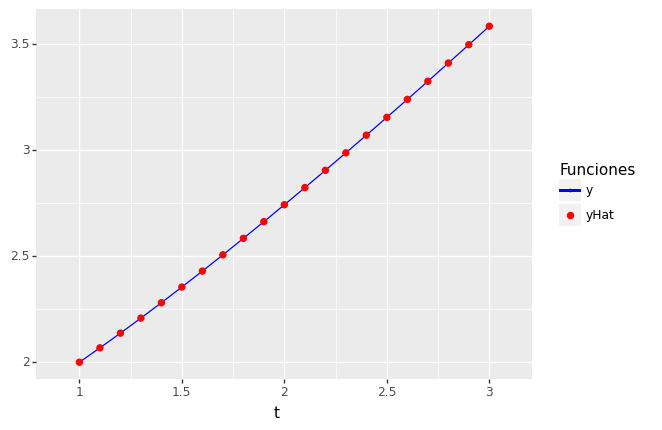

In [ ]:
df = MetodoRungeKutta4(a, b, n, y0, f, y = y, verbose = False, complete = True)
HelperPlot(df)

## Método Runge-Kutta-Fehlberg

El **Método Runge-Kutta-Fehlberg** es un método de **Runge-Kutta** con orden de consistencia $5$, $\mathcal{O}(h^4)$

In [ ]:
def MetodoRungeKuttaFehlberg(a, b, hMin, hMax, TOL, y0, f, y = None, verbose = False, complete = False):
    """
    Calcula solución a ecuación en diferencias con el método de Runge-Kutta-Fehlberg

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        hMin: (float) Paso mínimo
        hMax: (float) Paso Máximo
        TOL: (float) Tolerancia
        y0: (float) Condición inicial
        f: (fun) Función f(t, y)
        y: (fun) Función y(t) original. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces y debe ser distinto de None

    Returns:
        yHat: (ndarray) Vector de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and y == None:
        print("Si complete = True, entonces debes indicar una función para el parámetro y")
        return

    sep = 30
    i = 0

    t = a
    yHat = y0
    h = hMax

    T = np.array([t])
    YHAT = np.array([yHat])
    H = np.array([])

    if (y != None):
        Y = np.array([y(t)])

    while t <= b:
        if verbose:
            print("t =", t, end = "\n\n")
            
        k1 = f(t, yHat)
        k2 = f(t + h / 4, yHat + h / 4 * k1)
        k3 = f(t + 3 * h / 8, yHat + h * (3 / 32 * k1 + 9 / 32 * k2))
        k4 = f(t + 12 * h / 13, yHat + h * (1932 / 2197 * k1 - 7200 / 2197 * k2 + 7296 / 2197 * k3))
        k5 = f(t + h, yHat + h * (439 / 216 * k1 - 8 * k2 + 3680 / 513 * k3 - 845 / 4104 * k4))
        k6 = f(t + h / 2, yHat + h * (-8 / 27 * k1 + 2 * k2 - 3544 / 2565 * k3 + 1859 / 4104 * k4 - 11 / 40 * k5))
        R = abs(1 / 360 * k1 - 128 / 4275 * k3 - 2197 / 75240 * k4 + 1 / 50 * k5 + 2 / 55 * k6)
        
        if verbose:
            print("k1 = {},\nk2 = {},\nk3 = {},\nk4 = {},\nk5 = {},\nk6 = {}".format(k1, k2, k3, k4, k5, k6),
              end = "\n\n")
            print("R =", R, end = "\n\n")

        if R <= TOL:
            t += h
            yHat += h * (25 / 216 * k1 + 1408 / 2565 * k3 + 2197 / 4104 * k4 - 1 / 5 * k5)

            if (h != 0):
                T = np.append(T, t)
                YHAT = np.append(YHAT, yHat)
                H = np.append(H, h)
                
                if (y != None):
                    Y = np.append(Y, y(t))

            if verbose:
                print("yHat = {}".format(yHat), end = "\n\n")

        q = 0.84 * math.pow(TOL / R, 1 / 4)
        if verbose:
            print("q =", q, end = "\n\n")
        
        if q <= 0.1:
            h = 0.1 * h
        else:
            h = min(4 * h, hMax) if (q >= 4) else min(q * h, hMax)

        if verbose:
            print("h =", h, end = "\n\n")
        
        if t + h > b:
            h = b - t
        else:
            if t == b:
                H = np.append(H, None)
                data = pd.DataFrame({"t": T, "yHat": YHAT, "h": H})
                if (y != None):
                    data["y"] = Y
                    data["|y - yHat|"] = abs(Y - YHAT)
                if verbose:
                    print("=" * sep, end = "\n\n")
                    print(data)
                
                if complete:
                    return data
                return yHat

            if h < hMin:
                print("El paso h = {} es demasiado pequeño. El algoritmo no funciona".format(h))
                return   
        
        if verbose:
            print("=" * sep, end = "\n\n")

In [ ]:
a = 0
b = 1
hMin = 0.01
hMax = 0.25
TOL = 0.00001
y0 = 0

def f(t, y):
    return t * math.exp(3 * t) - 2 * y

def y(t):
    return 1 / 5 * t * math.exp(3 * t) - 1 / 25 * math.exp(3 * t) + 1 / 25 * math.exp(-2 * t)

In [ ]:
yHat = MetodoRungeKuttaFehlberg(a, b, hMin, hMax, TOL, y0, f, y = y, verbose = True)

t = 0

k1 = 0.0,
k2 = 0.07538939058881129,
k3 = 0.11359693807927954,
k4 = 0.3960624907247191,
k5 = 0.46413833497922263,
k6 = 0.1590779124915151

R = 0.00010117039907377168

q = 0.4709945917125248

h = 0.1177486479281312


t = 0

k1 = 0.0,
k2 = 0.03215504551563863,
k3 = 0.0482802882862029,
k4 = 0.13765147460961055,
k5 = 0.15332871899573658,
k6 = 0.0660583967437157

R = 3.7042353418165544e-06

yHat = 0.008186569732741499

q = 1.0767246193186877

h = 0.12678286811570724


t = 0.1177486479281312

k1 = 0.151263402323702,
k2 = 0.2080231190021048,
k3 = 0.23659523984698555,
k4 = 0.39837532636865747,
k5 = 0.4273469089483787,
k6 = 0.26833144184311686

R = 8.082884033920254e-06

yHat = 0.04307398125942798

q = 0.8859061142667

h = 0.11231771804797369


t = 0.24453151604383844

k1 = 0.42310188145075583,
k2 = 0.5077142844717683,
k3 = 0.550234001961674,
k4 = 0.7832997009105178,
k5 = 0.8235813451453349,
k6 = 0.5969751285650386

R = 7.985787243303816e-06

yHat = 0.11109556256496844

q = 0.888586789117

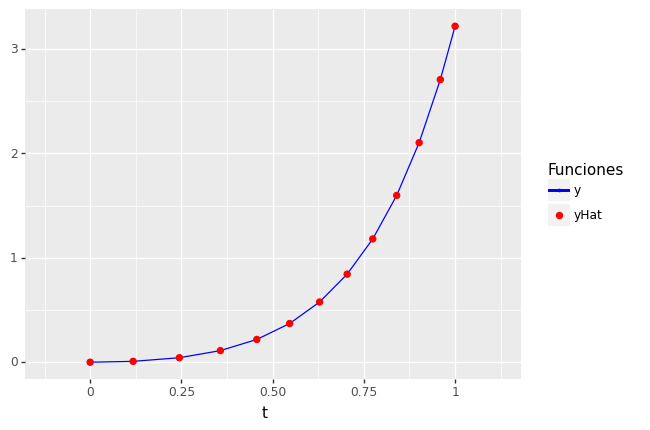

In [ ]:
df = MetodoRungeKuttaFehlberg(a, b, hMin, hMax, TOL, y0, f, y = y, verbose = False, complete = True)
HelperPlot(df)

## Método Adams-Bashforth de Orden 4

El **Método Adams-Bashforth** es un método multipaso. En este caso hemos implementado el método multipaso Adams-Bashforth de orden 4.

In [ ]:
def MetodoAdamsBashforth4(a, b, n, y0, f, y = None, verbose = False, complete = False):
    """
    Ofrece una solución aproximada calculada mediante el método 
    multipaso Adams-Bashforth de orden 4  

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        n: (int) Número de aproximaciones
        y0: (float) Condición inicial
        f: (fun) Función f(t, y)
        y: (fun) Función y(t) original. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces y debe ser distinto de None

    Returns:
        yHat: (ndarray) Vector de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and y == None:
        print("Si complete = True, entonces debes indicar una función para el parámetro y")
        return

    h = (b - a) / n
    if (verbose):
        print("h =", h, end = "\n\n")

    t = np.zeros(n + 1) # Ponemos n + 1 porque también incluimos el índice 0
    t[0] = a

    yHat = np.zeros(n + 1)
    yHat[0] = y0 # La primera componente del vector de aproximaciones vale la condición inicial

    if (y != None):
        yOriginal = np.zeros(n + 1)
        yOriginal[0] = y(t[0])

    for i in range(1, 4):
        # Calculamos los valores iniciales restantes usando el método Runge-Kutta 4
        t[i] = a + i * h 
        yHat[i] = MetodoRungeKutta4(a, t[i], i, y0, f)[-1] # Queremos solamente la última aproximación
        if (y != None):
            yOriginal[i] = y(t[i])

    for i in range(4, n + 1):
        yHat[i] = yHat[i - 1] + h / 24 * (55 * f(t[i - 1], yHat[i - 1]) - 
                                          59 * f(t[i - 1] - h, yHat[i - 2]) +
                                          37 * f(t[i - 1] - 2 * h, yHat[i - 3]) - 
                                          9 * f(t[i - 1] - 3 * h, yHat[i - 4]))
        t[i] = a + i * h
        if (y != None):
            yOriginal[i] = y(t[i]) 

    data = pd.DataFrame({"t": t, "yHat": yHat})
    if (y != None):
        data["y"] = yOriginal
        data["|y - yHat|"] = abs(yOriginal - yHat)
    if verbose:
        print(data)
    
    if complete:
        return data
    return yHat

In [ ]:
a = 0
b = 1
n = 10 # De este modo conseguimos h = 0.1
y0 = 0

def f(t, y):
    return t * math.exp(3 * t) - 2 * y

def y(t):
    return 1 / 5 * t * math.exp(3 * t) - 1 / 25 * math.exp(3 * t) + 1 / 25 * math.exp(-2 * t)

In [ ]:
yHat = MetodoAdamsBashforth4(a, b, n, y0, f, y = y, verbose = True)

h = 0.1

      t      yHat         y  |y - yHat|
0   0.0  0.000000  0.000000    0.000000
1   0.1  0.005755  0.005752    0.000003
2   0.2  0.026819  0.026813    0.000006
3   0.3  0.071155  0.071145    0.000011
4   0.4  0.150274  0.150778    0.000503
5   0.5  0.282614  0.283617    0.001002
6   0.6  0.494179  0.496020    0.001841
7   0.7  0.823656  0.826481    0.002824
8   0.8  1.326578  1.330857    0.004279
9   0.9  2.083567  2.089774    0.006208
10  1.0  3.210138  3.219099    0.008962


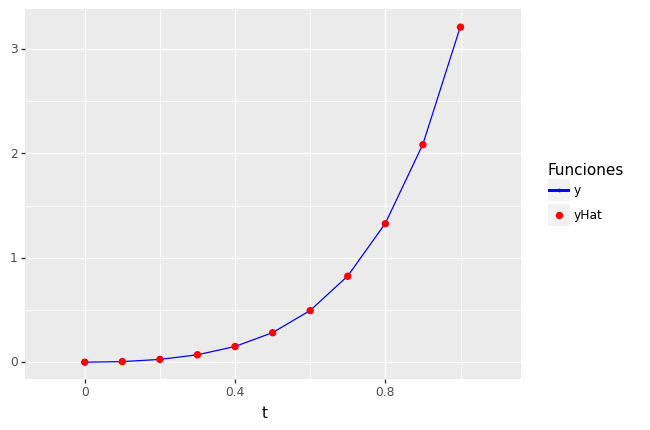

In [ ]:
df = MetodoAdamsBashforth4(a, b, n, y0, f, y = y, verbose = False, complete = True)
HelperPlot(df)

## Método Adams-Moulton de Orden 3

El **Método Adams-Moulton** es un método multipaso. En este caso hemos implementado el método multipaso Adams-Moulton de orden 3.

In [ ]:
def MetodoAdamsMoulton3(a, b, n, y0, f, y = None, verbose = False, complete = False):
    """
    Ofrece una solución aproximada calculada mediante el método 
    multipaso Adams-Moulton de orden 3  

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        n: (int) Número de aproximaciones
        y0: (float) Condición inicial
        f: (fun) Función f(t, y)
        y: (fun) Función y(t) original. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces y debe ser distinto de None

    Returns:
        yHat: (ndarray) Vector de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and y == None:
        print("Si complete = True, entonces debes indicar una función para el parámetro y")
        return

    h = (b - a) / n
    if (verbose):
        print("h =", h, end = "\n\n")

    t = np.zeros(n + 1) # Ponemos n + 1 porque también incluimos el índice 0
    t[0] = a

    yHat = np.zeros(n + 1)
    yHat[0] = y0 # La primera componente del vector de aproximaciones vale la condición inicial

    if (y != None):
        yOriginal = np.zeros(n + 1)
        yOriginal[0] = y(t[0])

    for i in range(1, 3):
        # Calculamos los valores iniciales restantes usando el método Runge-Kutta 4
        t[i] = a + i * h 
        yHat[i] = MetodoRungeKutta4(a, t[i], i, y0, f)[-1] # Queremos solamente la última aproximación
        if (y != None):
            yOriginal[i] = y(t[i])

    x = sp.Symbol('x')
    for i in range(3, n + 1):
        g = yHat[i - 1] + h / 24 * (9 * f(t[i - 1] + h, x) + 
                                          19 * f(t[i - 1], yHat[i - 1]) -
                                          5 * f(t[i - 1] - h, yHat[i - 2]) + 
                                          f(t[i - 1] - 2 * h, yHat[i - 3])) - x
        yHat[i] = NewtonRaphson(t[i - 1], g, x)
        t[i] = a + i * h
        
        if (y != None):
            yOriginal[i] = y(t[i]) 

    data = pd.DataFrame({"t": t, "yHat": yHat})
    if (y != None):
        data["y"] = yOriginal
        data["|y - yHat|"] = abs(yOriginal - yHat)
    if verbose:
        print(data)
    
    if complete:
        return data
    return yHat

In [ ]:
a = 0
b = 1
n = 10 # De este modo conseguimos h = 0.1
y0 = 0

def f(t, y):
    return t * math.exp(3 * t) - 2 * y

def y(t):
    return 1 / 5 * t * math.exp(3 * t) - 1 / 25 * math.exp(3 * t) + 1 / 25 * math.exp(-2 * t)

In [ ]:
yHat = MetodoAdamsMoulton3(a, b, n, y0, f, y = y, verbose = True)

h = 0.1

      t      yHat         y  |y - yHat|
0   0.0  0.000000  0.000000    0.000000
1   0.1  0.005755  0.005752    0.000003
2   0.2  0.026819  0.026813    0.000006
3   0.3  0.071182  0.071145    0.000038
4   0.4  0.150855  0.150778    0.000077
5   0.5  0.283745  0.283617    0.000129
6   0.6  0.496219  0.496020    0.000200
7   0.7  0.826778  0.826481    0.000297
8   0.8  1.331289  1.330857    0.000432
9   0.9  2.090396  2.089774    0.000621
10  1.0  3.219985  3.219099    0.000886


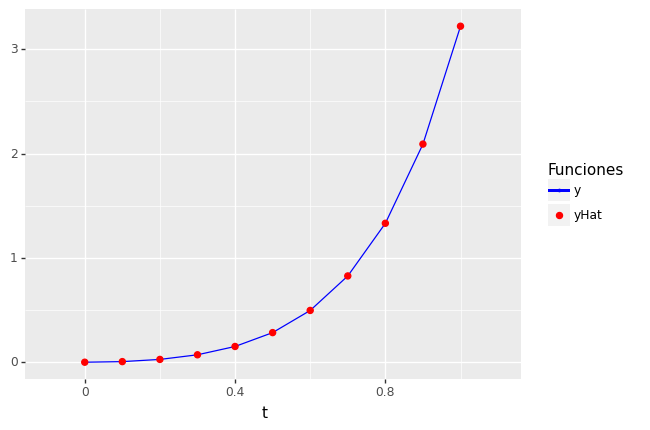

In [ ]:
df = MetodoAdamsMoulton3(a, b, n, y0, f, y = y, verbose = False, complete = True)
HelperPlot(df)

## Método Predictor-Corrector de Orden 4

Este método combina el método explícito de Adams-Bashforth de orden 4 como predictor y el método implícito Adams-Moulton de orden 3 como corrector.

In [ ]:
def MetodoPredictorCorrector4(a, b, n, y0, f, y = None, verbose = False, complete = False):
    """
    Ofrece una solución aproximada calculada mediante el método 
    predictor-corrector de orden 4. Como predictor usa el método
    Adams-Bashforth de orden 4 y como corrector, el método Adams-
    Moulton de orden 3. 

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        n: (int) Número de aproximaciones
        y0: (float) Condición inicial
        f: (fun) Función f(t, y)
        y: (fun) Función y(t) original. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces y debe ser distinto de None

    Returns:
        yHat: (ndarray) Vector de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and y == None:
        print("Si complete = True, entonces debes indicar una función para el parámetro y")
        return

    h = (b - a) / n
    if (verbose):
        print("h =", h, end = "\n\n")

    t = np.zeros(n + 1) # Ponemos n + 1 porque también incluimos el índice 0
    t[0] = a

    yHat = np.zeros(n + 1)
    yHat[0] = y0 # La primera componente del vector de aproximaciones vale la condición inicial

    if (y != None):
        yOriginal = np.zeros(n + 1)
        yOriginal[0] = y(t[0])

    for i in range(1, 4):
        # Calculamos los valores iniciales restantes usando el método Runge-Kutta 4
        t[i] = a + i * h 
        yHat[i] = MetodoRungeKutta4(a, t[i], i, y0, f)[-1] # Queremos solamente la última aproximación
        if (y != None):
            yOriginal[i] = y(t[i])

    for i in range(4, n + 1):
        predictor = yHat[i - 1] + h / 24 * (55 * f(t[i - 1], yHat[i - 1]) -
                                      59 * f(t[i - 1] - h, yHat[i - 2]) +
                                      37 * f(t[i - 1] - 2 * h, yHat[i - 3]) -
                                      9 * f(t[i - 1] - 3 * h, yHat[i - 4]))
        yHat[i] = yHat[i - 1] + h / 24 * (9 * f(t[i - 1] + h, predictor) +
                                          19 * f(t[i - 1], yHat[i - 1]) -
                                          5 * f(t[i - 1] - h, yHat[i - 2]) +
                                          f(t[i - 1] - 2 * h, yHat[i - 3]))
        t[i] = a + i * h
        
        if (y != None):
            yOriginal[i] = y(t[i]) 

    data = pd.DataFrame({"t": t, "yHat": yHat})
    if (y != None):
        data["y"] = yOriginal
        data["|y - yHat|"] = abs(yOriginal - yHat)
    if verbose:
        print(data)
    
    if complete:
        return data
    return yHat

In [ ]:
a = 0
b = 1
n = 10 # De este modo conseguimos h = 0.1
y0 = 0

def f(t, y):
    return t * math.exp(3 * t) - 2 * y

def y(t):
    return 1 / 5 * t * math.exp(3 * t) - 1 / 25 * math.exp(3 * t) + 1 / 25 * math.exp(-2 * t)

In [ ]:
yHat = MetodoPredictorCorrector4(a, b, n, y0, f, y = y, verbose = True)

h = 0.1

      t      yHat         y  |y - yHat|
0   0.0  0.000000  0.000000    0.000000
1   0.1  0.005755  0.005752    0.000003
2   0.2  0.026819  0.026813    0.000006
3   0.3  0.071155  0.071145    0.000011
4   0.4  0.150875  0.150778    0.000098
5   0.5  0.283822  0.283617    0.000206
6   0.6  0.496367  0.496020    0.000347
7   0.7  0.827020  0.826481    0.000539
8   0.8  1.331659  1.330857    0.000802
9   0.9  2.090941  2.089774    0.001167
10  1.0  3.220775  3.219099    0.001675


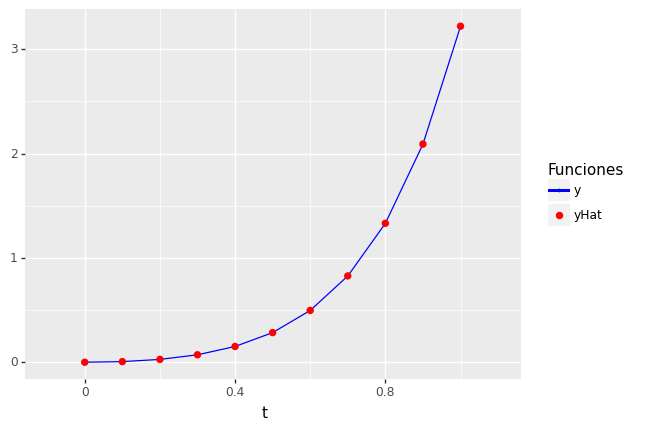

In [ ]:
df = MetodoPredictorCorrector4(a, b, n, y0, f, y = y, verbose = False, complete = True)
HelperPlot(df)

## Método de Euler para Sistemas

Podemos adaptar el problema de valores iniciales correspondiente a una ecuación diferencial al problema de valores iniciales correspondiente a un sistema de ecuaciones diferenciales.

In [ ]:
def MetodoEulerSistema(a, b, n, y0List, fList, yList = None, verbose = False, complete = False):
    """
    Ofrece una solución aproximada a un sistema de m ecuaciones 
    diferenciales mediante el método de Euler

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        n: (int) Número de aproximaciones
        y0List: (list) Vector de condiciones iniciales y0_i
        fList: (list) Lista de funciones f_i(t, y1,..., ym)
        yList: (list) Lista de funciones y_i(t) originales. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces yList debe ser distinto de None

    Returns:
        yHat: (ndarray) Matriz de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and yList == None:
        print("Si complete = True, entonces debes indicar una lista de funciones para el parámetro yList")
        return

    m = len(fList)
    if (verbose):
        print("El sistema tiene {} ecuaciones".format(m), end = "\n\n")

    h = (b - a) / n
    if (verbose):
        print("h =", h, end = "\n\n")

    t = np.zeros(n + 1) # Ponemos n + 1 porque también incluimos el índice 0
    t[0] = a

    yHat = np.zeros((m, n + 1))
    yHat[:, 0] = np.array(y0List) # La primera columna de la matriz de aproximaciones vale la condición inicial

    if (yList != None):
        yOriginal = np.zeros((m, n + 1))
        yOriginal[:, 0] = np.array([y(t[0]) for y in yList])

    for i in range(1, n + 1):
        for j in range(m):
            yHat[j, i] = yHat[j, i - 1] + h * fList[j](t[i - 1], yHat[:, i - 1]) # Calculamos yHat(t + i * h)
        
        t[i] = a + i * h 
        if (yList != None):
            yOriginal[:, i] = np.array([y(t[i]) for y in yList])

        
    
    data = pd.DataFrame({"t": t})
    for col in range(m):
        data["yHat" + str(col + 1)] = yHat[col, :]
    if (yList != None):
        for col in range(m):
            data["y" + str(col + 1)] = yOriginal[col, :]
        data["||y - yHat||"] = np.sqrt(np.sum(np.power(yOriginal - yHat, 2), axis = 0))
    if verbose:
        print(data)
    
    if complete:
        return data
    return yHat

In [ ]:
a = 0
b = 1
n = 10 # De este modo conseguimos h = 0.1
y0 = [1, 1]

def f1(t, yList):
    return 3 * yList[0] + 2 * yList[1] - (2 * math.pow(t, 2) + 1) * math.exp(2 * t)

def f2(t, yList):
    return 4 * yList[0] + yList[1] + (math.pow(t, 2) + 2 * t - 4) * math.exp(2 * t)

def y1(t):
    return 1 / 3 * math.exp(5 * t) - 1 / 3 * math.exp(-t) + math.exp(2 * t)

def y2(t):
    return 1 / 3 * math.exp(5 * t) + 2 / 3 * math.exp(-t) + math.pow(t, 2) * math.exp(2 * t)

In [ ]:
yHat = MetodoEulerSistema(a, b, n, y0, [f1, f2], yList = [y1, y2], verbose = True)

El sistema tiene 2 ecuaciones

h = 0.1

      t      yHat1      yHat2         y1         y2  ||y - yHat||
0   0.0   1.000000   1.000000   1.000000   1.000000      0.000000
1   0.1   1.400000   1.100000   1.469364   1.165013      0.095069
2   0.2   1.915417   1.307088   2.125008   1.511587      0.292828
3   0.3   2.590343   1.672874   3.069076   2.151766      0.677143
4   0.4   3.487010   2.273178   4.465120   3.265985      1.393688
5   0.5   4.693977   3.218735   6.576936   5.144756      2.693527
6   0.6   6.338175   4.670672   9.832359   8.256295      5.006597
7   0.7   8.602702   6.862901  14.928156  13.356589      9.065282
8   0.8  11.753163  10.134624  23.002639  21.668877     16.111787
9   0.9  16.176746  14.977619  35.919835  35.176971     28.245414
10  1.0  22.440286  22.105178  56.737483  57.105362     49.003170


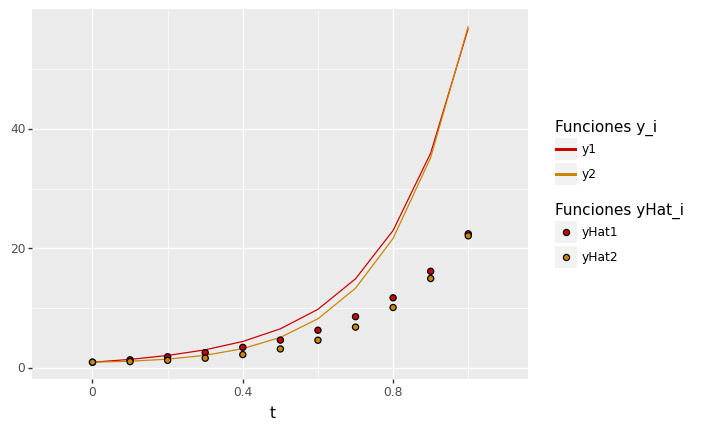

In [ ]:
df = MetodoEulerSistema(a, b, n, y0, [f1, f2], yList = [y1, y2], verbose = False, complete = True)
HelperPlotSistema(df)

## Método de Taylor de Orden 2 para Sistemas

In [ ]:
def MetodoTaylor2Sistema(a, b, n, y0List, fList, ftList, fyList, yList = None, verbose = False, 
                         complete = False):
    """
    Ofrece una solución aproximada a un sistema de m ecuaciones 
    diferenciales mediante el método de Taylor de orden 2 

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        n: (int) Número de aproximaciones
        y0List: (list) Vector de condiciones iniciales y0_i
        fList: (list) Lista de funciones f_i(t, y1,..., ym)
        ftList: (list) Lista de funciones ft_i(t, y1,..., ym)
        fyList: (list) Lista bidimensional de funciones fy_i(t, y1,..., ym) donde cada fila se
            corresponde con las parciales de f_i y cada columna, con las parcial con respecto y_j
        yList: (list) Lista de funciones y_i(t) originales. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces yList debe ser distinto de None

    Returns:
        yHat: (ndarray) Matriz de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and yList == None:
        print("Si complete = True, entonces debes indicar una lista de funciones para el parámetro yList")
        return

    m = len(fList)
    if (verbose):
        print("El sistema tiene {} ecuaciones".format(m), end = "\n\n")

    h = (b - a) / n
    if (verbose):
        print("h =", h, end = "\n\n")

    t = np.zeros(n + 1) # Ponemos n + 1 porque también incluimos el índice 0
    t[0] = a

    yHat = np.zeros((m, n + 1))
    yHat[:, 0] = np.array(y0List)# La primera columna de la matriz de aproximaciones vale la condición inicial

    if (yList != None):
        yOriginal = np.zeros((m, n + 1))
        yOriginal[:, 0] = np.array([y(t[0]) for y in yList])

    for i in range(1, n + 1):
        for j in range(m):
            yHat[j, i] = yHat[j, i - 1] + h * (fList[j](t[i - 1], yHat[:, i - 1]) +
                          h / 2 * (ftList[j](t[i - 1], yHat[:, i - 1]) +
                          np.sum([(fyList[j][l](t[i - 1], yHat[:, i - 1]) * 
                                   fList[l](t[i - 1], yHat[:, i - 1])) for l in range(m)])))

        t[i] = a + i * h 
        if (yList != None):
            yOriginal[:, i] = np.array([y(t[i]) for y in yList])

        
    
    data = pd.DataFrame({"t": t})
    for col in range(m):
        data["yHat" + str(col + 1)] = yHat[col, :]
    if (yList != None):
        for col in range(m):
            data["y" + str(col + 1)] = yOriginal[col, :]
        data["||y - yHat||"] = np.sqrt(np.sum(np.power(yOriginal - yHat, 2), axis = 0))
    if verbose:
        print(data)
    
    if complete:
        return data
    return yHat

In [ ]:
a = 0
b = 1
n = 10 # De este modo conseguimos h = 0.1
y0 = [1, 1]

def f1(t, yList):
    return 3 * yList[0] + 2 * yList[1] - (2 * math.pow(t, 2) + 1) * math.exp(2 * t)

def f2(t, yList):
    return 4 * yList[0] + yList[1] + (math.pow(t, 2) + 2 * t - 4) * math.exp(2 * t)

def y1(t):
    return 1 / 3 * math.exp(5 * t) - 1 / 3 * math.exp(-t) + math.exp(2 * t)

def y2(t):
    return 1 / 3 * math.exp(5 * t) + 2 / 3 * math.exp(-t) + math.pow(t, 2) * math.exp(2 * t)

def ft1(t, yList):
    return -2 * (2 * math.pow(t, 2) + 2 * t + 1) * math.exp(2 * t)

def ft2(t, yList):
    return 2 * (math.pow(t, 2) + 3 * t - 3) * math.exp(2 * t)  

def f1y1(t, yList):
    return 3

def f1y2(t, yList):
    return 2   

def f2y1(t, yList):
    return 4

def f2y2(t, yList):
    return 1  

In [ ]:
yHat = MetodoTaylor2Sistema(a, b, n, y0, [f1, f2], [ft1, ft2], [[f1y1, f1y2], [f2y1, f2y2]], 
                            yList = [y1, y2], verbose = True)

El sistema tiene 2 ecuaciones

h = 0.1

      t      yHat1      yHat2         y1         y2  ||y - yHat||
0   0.0   1.000000   1.000000   1.000000   1.000000      0.000000
1   0.1   1.460000   1.155000   1.469364   1.165013      0.013709
2   0.2   2.094837   1.479445   2.125008   1.511587      0.044084
3   0.3   2.995944   2.074412   3.069076   2.151766      0.106451
4   0.4   4.307234   3.100351   4.465120   3.265985      0.228829
5   0.5   6.256928   4.811728   6.576936   5.144756      0.461858
6   0.6   9.209047   7.612324   9.832359   8.256295      0.896224
7   0.7  13.746810  12.143738  14.928156  13.356589      1.693099
8   0.8  20.807829  19.427407  23.002639  21.668877      3.137097
9   0.9  31.903385  31.092942  35.919835  35.176971      5.728103
10  1.0  49.474251  49.745949  56.737483  57.105362     10.339995


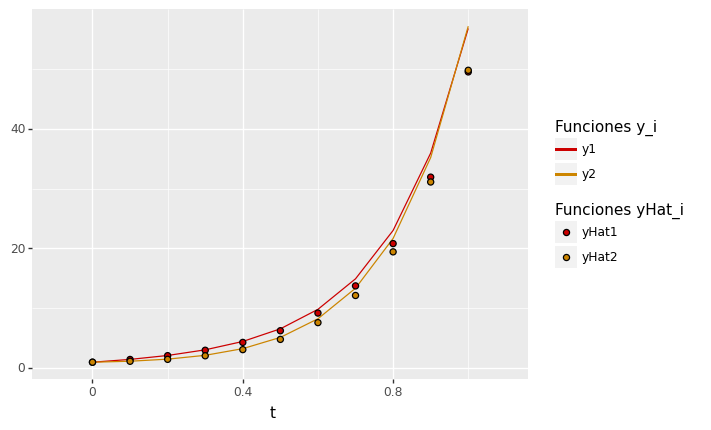

In [ ]:
df = MetodoTaylor2Sistema(a, b, n, y0, [f1, f2], [ft1, ft2], [[f1y1, f1y2], [f2y1, f2y2]], 
                            yList = [y1, y2], verbose = False, complete = True)
HelperPlotSistema(df)

## Método Runge-Kutta 4 para Sistemas

In [ ]:
def MetodoRungeKutta4Sistema(a, b, n, y0List, fList, yList = None, verbose = False, complete = False):
    """
    Ofrece una solución aproximada a un sistema de m ecuaciones 
    diferenciales mediante el método de Runge Kutta de orden 4 

    Args:
        a: (float) Valor inicial
        b: (float) Valor final
        n: (int) Número de aproximaciones
        y0List: (list) Vector de condiciones iniciales y0_i
        fList: (list) Lista de funciones f_i(t, y1,..., ym)
        yList: (list) Lista de funciones y_i(t) originales. Parámetro opcional.
        verbose: (bool) Para mostrar o no los resultados relevantes
        complete: (bool) Para devolver o no el dataframe completo de resultados.
            Si vale True, entonces yList debe ser distinto de None

    Returns:
        yHat: (ndarray) Matriz de aproximaciones si complete = False
              (dataframe) Dataframe con los datos t, yHat, y e |y - yHat|
                para cada iteración si complete = True
    """

    if complete and yList == None:
        print("Si complete = True, entonces debes indicar una lista de funciones para el parámetro yList")
        return

    m = len(fList)
    if (verbose):
        print("El sistema tiene {} ecuaciones".format(m), end = "\n\n")

    h = (b - a) / n
    if (verbose):
        print("h =", h, end = "\n\n")

    t = np.zeros(n + 1) # Ponemos n + 1 porque también incluimos el índice 0
    t[0] = a

    yHat = np.zeros((m, n + 1))
    yHat[:, 0] = np.array(y0List) # La primera columna de la matriz de aproximaciones vale la condición inicial

    if (yList != None):
        yOriginal = np.zeros((m, n + 1))
        yOriginal[:, 0] = np.array([y(t[0]) for y in yList])

    k = np.zeros((m , 4))
    for i in range(1, n + 1):
        for j in range(m):
            k[j, 0] = fList[j](t[i - 1], yHat[:, i - 1])
        for j in range(m):
            k[j, 1] = fList[j](t[i - 1] + h / 2, yHat[:, i - 1] + (h * k[:, 0] / 2))
        for j in range(m):
            k[j, 2] = fList[j](t[i - 1] + h / 2, yHat[:, i - 1] + (h * k[:, 1] / 2))
        for j in range(m):
            k[j, 3] = fList[j](t[i - 1] + h, yHat[:, i - 1] + (h * k[:, 2]))
        for j in range(m):
            yHat[j, i] = yHat[j, i - 1] + h / 6 * (k[j, 0] + 2 * k[j, 1] +
                                                   2 * k[j, 2] + k[j, 3])

        t[i] = a + i * h 
        if (yList != None):
            yOriginal[:, i] = np.array([y(t[i]) for y in yList])
        
        if verbose:
            for i in range(4):
                for j in range(m):
                    print("k({}, {}) = {}".format(j, i, k[j, i]), end = "\t")
                print("")
            print("\n\n" + "=" * 75, end = "\n\n")
    
    data = pd.DataFrame({"t": t})
    for col in range(m):
        data["yHat" + str(col + 1)] = yHat[col, :]
    if (yList != None):
        for col in range(m):
            data["y" + str(col + 1)] = yOriginal[col, :]
        data["||y - yHat||"] = np.sqrt(np.sum(np.power(yOriginal - yHat, 2), axis = 0))
    if verbose:
        print(data)
    
    if complete:
        return data
    return yHat

In [ ]:
a = 0
b = 1
n = 10 # De este modo conseguimos h = 0.1
y0 = np.ones(2)

def f1(t, yList):
    return 3 * yList[0] + 2 * yList[1] - (2 * math.pow(t, 2) + 1) * math.exp(2 * t)

def f2(t, yList):
    return 4 * yList[0] + yList[1] + (math.pow(t, 2) + 2 * t - 4) * math.exp(2 * t)

def y1(t):
    return 1 / 3 * math.exp(5 * t) - 1 / 3 * math.exp(-t) + math.exp(2 * t)

def y2(t):
    return 1 / 3 * math.exp(5 * t) + 2 / 3 * math.exp(-t) + math.pow(t, 2) * math.exp(2 * t)

In [ ]:
yHat = MetodoRungeKutta4Sistema(a, b, n, y0, [f1, f2], yList = [y1, y2], verbose = True)

El sistema tiene 2 ecuaciones

h = 0.1

k(0, 0) = 4.0	k(1, 0) = 1.0	
k(0, 1) = 4.589303227333973	k(1, 1) = 1.5425963468001624	
k(0, 2) = 4.7319583461140855	k(1, 2) = 1.687586809606966	
k(0, 3) = 5.511274052432245	k(1, 3) = 2.432425565979286	



k(0, 0) = 5.491618775936162	k(1, 0) = 2.412683224508072	
k(0, 1) = 6.391858274183844	k(1, 1) = 3.2966518294870015	
k(0, 2) = 6.615291059418889	k(1, 2) = 3.5208981593854842	
k(0, 3) = 7.815045865509728	k(1, 3) = 4.729109994038298	



k(0, 0) = 7.784890187782577	k(1, 0) = 4.698582861513808	
k(0, 1) = 9.178841246016272	k(1, 1) = 6.133906597717244	
k(0, 2) = 9.53146627837167	k(1, 2) = 6.484462996174157	
k(0, 3) = 11.402293159520681	k(1, 3) = 8.43929836679023	



k(0, 0) = 11.355504610447866	k(1, 0) = 8.391695789164203	
k(0, 1) = 13.540977944591525	k(1, 1) = 10.714895502017132	
k(0, 2) = 14.101118915998363	k(1, 2) = 11.26815015448851	
k(0, 3) = 17.051856474995823	k(1, 3) = 14.42452717768788	



k(0, 0) = 16.9785456522919	k(1, 0) = 14.34974015427897	


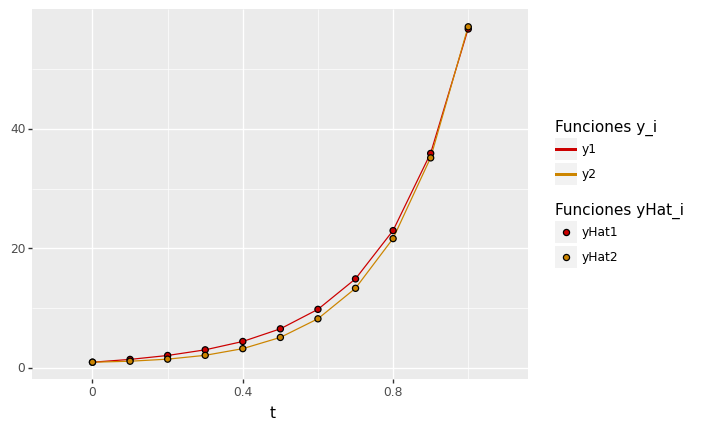

In [ ]:
df = MetodoRungeKutta4Sistema(a, b, n, y0, [f1, f2], yList = [y1, y2], verbose = False, complete = True)
HelperPlotSistema(df)